    val_acc
1  0.097778
2  0.172111
3  0.179111
4  0.246556
5  0.166889
    val_acc
1  0.061333
2  0.123667
3  0.189556
4  0.172000
5  0.211333


<AxesSubplot:xlabel='Epochs', ylabel='Accuracy'>

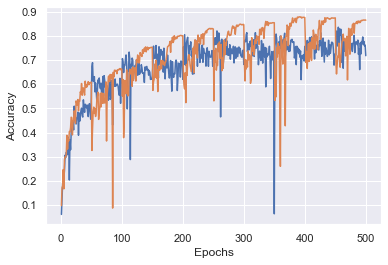

In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def get_graph_data(path, columns_to_drop):
    raw_data = pd.read_csv(path)
    raw_data = raw_data.drop(columns_to_drop, axis=1)
    raw_data.index += 1
    print(raw_data.head())
    return raw_data

snapshot_data = get_graph_data('ResNet-CIFAR100-40-12-snapshot/training.csv', ['Unnamed: 0', 'Unnamed: 1', 'val_loss', 'loss', 'lr', 'acc'])
regular_data = get_graph_data('ResNet-CIFAR100-40-12/training.csv', ['Unnamed: 0', 'Unnamed: 1', 'val_loss', 'loss', 'acc'])
res = pd.DataFrame(index=[], columns=['Snapshots, Regular'])
res['Snapshots'] = snapshot_data['val_acc']
res['Regular'] = regular_data['val_acc']

sns.set_theme()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
sns.lineplot(data=res['Regular'])
sns.lineplot(data=res['Snapshots'])
# sns.lineplot(data=regular_data)

## Ensemble snapshots and produce results 'over_time'


In [25]:
import sys
sys.path.append("../..")
from models import dense_net as DN

import numpy as np
import sklearn.metrics as metrics
from scipy.optimize import minimize
from sklearn.metrics import log_loss

from tensorflow.keras.datasets import cifar100
from tensorflow.keras import backend as K
import tensorflow.keras.utils as kutils

In [26]:
(trainX, trainY), (testX, testY) = cifar100.load_data()
nb_classes = len(np.unique(testY))

trainX = trainX.astype('float32')
trainX /= 255.0
testX = testX.astype('float32')
testX /= 255.0

trainY = kutils.to_categorical(trainY)
testY_cat = kutils.to_categorical(testY)

NUM_TESTS=25

In [28]:
from models.resnet_alt import resnet_v1
img_rows = img_cols = 32
dense_net_model = resnet_v1((img_rows, img_cols, 3), 110, 100)

n_batches = 10
file_list =[f'ResNet-CIFAR100-40-12-snapshot/ResNet-CIFAR100-40-12-snapshot-{j}-1.h5' for j in range(n_batches)]

preds = []
for fn in file_list:
    dense_net_model.load_weights(fn)
    yPreds = dense_net_model.predict(testX, batch_size=128)
    preds.append(yPreds)

    print("Obtained predictions from model with weights = %s" % (fn))

Obtained predictions from model with weights = ResNet-CIFAR100-40-12-snapshot/ResNet-CIFAR100-40-12-snapshot-0-1.h5
Obtained predictions from model with weights = ResNet-CIFAR100-40-12-snapshot/ResNet-CIFAR100-40-12-snapshot-1-1.h5
Obtained predictions from model with weights = ResNet-CIFAR100-40-12-snapshot/ResNet-CIFAR100-40-12-snapshot-2-1.h5
Obtained predictions from model with weights = ResNet-CIFAR100-40-12-snapshot/ResNet-CIFAR100-40-12-snapshot-3-1.h5
Obtained predictions from model with weights = ResNet-CIFAR100-40-12-snapshot/ResNet-CIFAR100-40-12-snapshot-4-1.h5
Obtained predictions from model with weights = ResNet-CIFAR100-40-12-snapshot/ResNet-CIFAR100-40-12-snapshot-5-1.h5
Obtained predictions from model with weights = ResNet-CIFAR100-40-12-snapshot/ResNet-CIFAR100-40-12-snapshot-6-1.h5
Obtained predictions from model with weights = ResNet-CIFAR100-40-12-snapshot/ResNet-CIFAR100-40-12-snapshot-7-1.h5
Obtained predictions from model with weights = ResNet-CIFAR100-40-12-sna

In [ ]:
# Read active classes
with open('ResNet-CIFAR100-40-12/ResNet-CIFAR100-40-12-active-labels.csv') as file:
    # Skip first line and remove all of the empty lines
    lines = [l.replace('\n', '') for l in file.readlines()[1:] if l != '\n']
    active_labels = [[int(z) for z in l.split(',')] for l in lines][1:]

def get_active_for_classes(n_snapshots):
    batch_idx = np.array([i in active_labels[n_snapshots - 1] for i in testY]).nonzero()
    return batch_idx

# Create the loss metric
n_snapshots = 0
def log_loss_func(weights):
    ''' scipy minimize will pass the weights as a numpy array '''
    final_prediction = np.zeros((testX.shape[0], nb_classes), dtype='float32')

    for weight, prediction in zip(weights, preds[:n_snapshots]):
        final_prediction += weight * prediction

    idxs = get_active_for_classes(n_snapshots)
    return log_loss(testY_cat[idxs], final_prediction[idxs])

In [61]:
def get_accuracy_for_n_snapshots(n_snapshots):
    best_acc = 0.0
    best_weights = None

    # Parameters for optimization
    constraints = ({'type': 'eq', 'fun':lambda w: 1 - sum(w)})
    bounds = [(0, 1)] * n_snapshots

    # Check for NUM_TESTS times
    for iteration in range(NUM_TESTS):
        # Random initialization of weights
        prediction_weights = np.random.random(n_snapshots)
        
        # Minimise the loss 
        result = minimize(log_loss_func, prediction_weights, method='SLSQP', bounds=bounds, constraints=constraints)
        print('Best Ensemble Weights: {weights}'.format(weights=result['x']))
        
        weights = result['x']
        weighted_predictions = np.zeros((int(testX.shape[0] / 2), nb_classes), dtype='float32')
        
        # Calculate weighted predictions
        idxs = get_active_for_classes(n_snapshots)
        for weight, prediction in zip(weights, preds[:n_snapshots]):
            p = prediction[idxs]
            # print(np.array(prediction).shape)
            weighted_predictions += weight * p

        yPred = np.argmax(weighted_predictions, axis=1)
        yTrue = testY[idxs]

        # Calculate weight prediction accuracy
        accuracy = metrics.accuracy_score(yTrue, yPred) * 100
        error = 100 - accuracy
        print("Iteration %d: Accuracy : " % (iteration + 1), accuracy)
        print("Iteration %d: Error : " % (iteration + 1), error)
        
        # Save current best weights 
        if accuracy > best_acc:
            best_acc = accuracy
            best_weights = weights
            
        print()

        return accuracy

Best Ensemble Weights: [1.]
Iteration 1: Accuracy :  66.03999999999999
Iteration 1: Error :  33.96000000000001

Best Ensemble Weights: [0.52162812 0.47837188]
Iteration 1: Accuracy :  68.46
Iteration 1: Error :  31.540000000000006

Best Ensemble Weights: [0.73451193 0.21211676 0.05337131]
Iteration 1: Accuracy :  58.36
Iteration 1: Error :  41.64

Best Ensemble Weights: [0.51139636 0.19325605 0.02908432 0.26626327]
Iteration 1: Accuracy :  61.839999999999996
Iteration 1: Error :  38.160000000000004

Best Ensemble Weights: [4.83442672e-01 1.09819623e-03 3.51344151e-01 2.12728234e-04
 1.63902252e-01]
Iteration 1: Accuracy :  57.54
Iteration 1: Error :  42.46

Best Ensemble Weights: [0.41849886 0.00103226 0.32309125 0.00061903 0.0062481  0.25051051]
Iteration 1: Accuracy :  53.800000000000004
Iteration 1: Error :  46.199999999999996

Best Ensemble Weights: [5.35729721e-01 2.03484752e-01 2.98059332e-03 7.51455243e-03
 1.90676750e-02 2.30940406e-01 2.82300253e-04]
Iteration 1: Accuracy :  5

<AxesSubplot:>

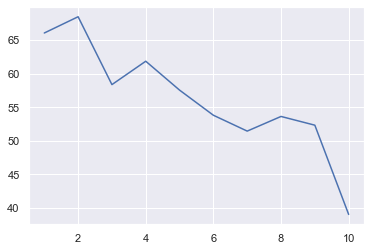

In [62]:
results = []
for i in range(1, n_batches + 1):
    # Compile list of units
    n_snapshots = i
    results.append(get_accuracy_for_n_snapshots(i))
    
# sns.lineplot(data=raw_data)
sns.lineplot(x=np.arange(1, len(results) + 1), y=results)